In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import numpy as np
import math
import warnings
from IPython.display import display, HTML

%matplotlib inline  
sns.set()


# Human Resources Analytics
This notebook investigates the question are our employees leaving prematurely? The data set is from https://www.kaggle.com/ludobenistant/hr-analytics. There are 14999 data points. There is one line per employee. Fields in the dataset include:

* Satisfaction Level
* Last evaluation - I think that this is a performance metric of the employee
* Number of projects
* Average monthly hours
* Time spent at the company
* Whether they have had a work accident
* Whether they have had a promotion in the last 5 years
* Departments
* Salary
* Whether the employee has left.

## Summary of contents

* [Loading of the training set and data exploration](#train) - The training set is loaded and sample data is displayed. Pairwise correlations of numerical variables and some summary statistics are displayed. Finally, continuous variables are plotted pairwise, as are some stacked bar charts of discrete variables vs number of leavers.
* [Clustering](#cluster) - There appeared to be three groups of leavers based on the preliminary analysis. We will use a clustering algorithm to group the groups in this part. 

<a class="anchor" id="train"></a>


## Loading of the training set and intial exploration <a class="anchor" id="train"></a>

In [2]:
# Load training data into a data frame. 
input_filename = "HR_comma_sep.csv"
df = pd.read_csv(input_filename) 

#Output some sample data
display(df.head())

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
#Output some information
display(df.describe())

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


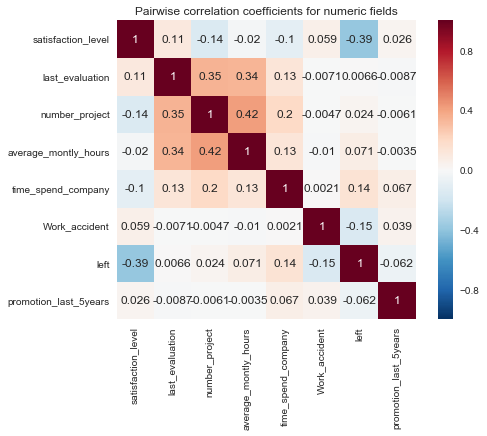

In [4]:
#Display pairwise correlations
g = sns.heatmap(df.corr(), square=True, annot = True);
g.set_title('Pairwise correlation coefficients for numeric fields');

Perhaps not surprisingly, there is a strong negative correlation between satisfaction and leaving the company. Let's do a pair plot of suitable to try and see any trends. First we'll convert salary to an integer value so that it can be part of the pair plot.

In [5]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [6]:
df['salary'] = df['salary'].replace({'low':1,'medium':2,'high':3})

df['salary'].head()

0    1
1    2
2    2
3    1
4    1
Name: salary, dtype: int64

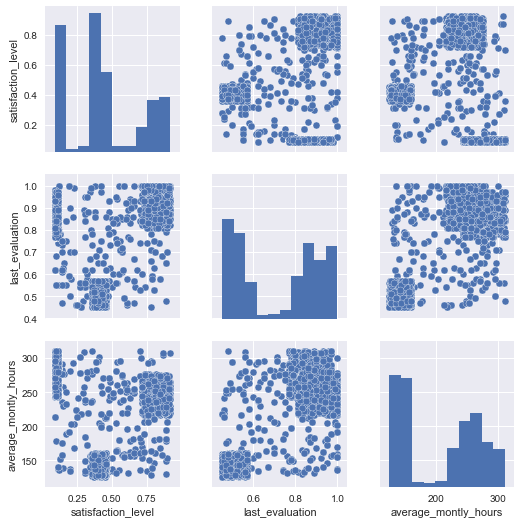

In [41]:
#Do a pairplot of the continuous variables. Only show those that left since that's what we care about.
g = sns.pairplot(df[df["left"] == 1], vars=['satisfaction_level','last_evaluation', 'average_montly_hours']);

There is clear clustering of the leavers here! More on that later on. First we'll do some bar plots to spot any patterns there.

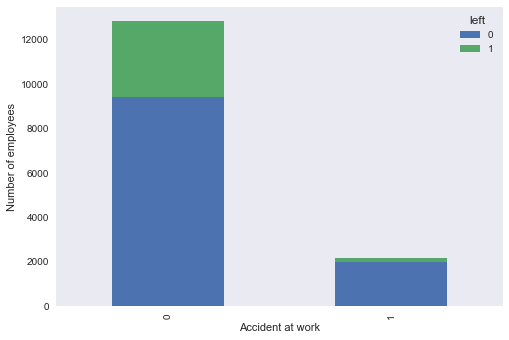

In [35]:
tab = pd.crosstab([df['Work_accident']],df['left'])
g = tab.plot(kind='bar', stacked=True, grid=False);
g.set_xlabel('Accident at work');
g.set_ylabel('Number of employees');

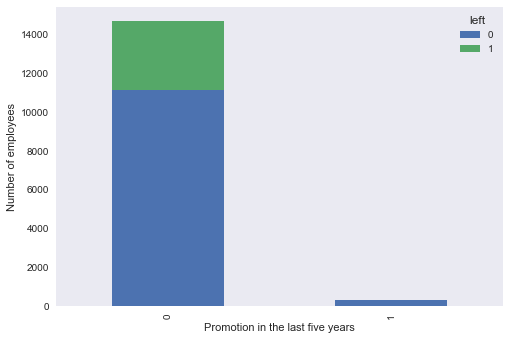

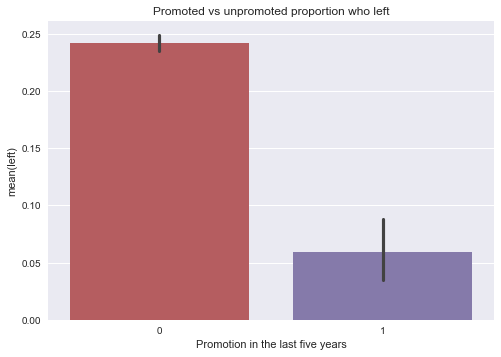

In [75]:
tab = pd.crosstab([df['promotion_last_5years']],df['left'])
g = tab.plot(kind='bar', stacked=True, grid=False);
g.set_xlabel('Promotion in the last five years');
g.set_ylabel('Number of employees');

#We'll also plot proportion of leavers since there are only a few people that got promoted and the proportion isn't clear there.
f, ax = plt.subplots()
g = sns.barplot(x='promotion_last_5years', y="left", data=df, palette=sns.color_palette()[2:4]); #use the next two colours
ax.set_title("Promoted vs unpromoted proportion who left");
g.set_xlabel('Promotion in the last five years');

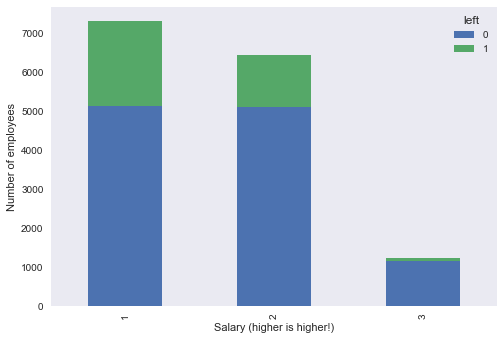

In [38]:
tab = pd.crosstab([df['salary']],df['left'])
g = tab.plot(kind='bar', stacked=True, grid=False);
g.set_xlabel('Salary (higher is higher!)');
g.set_ylabel('Number of employees');

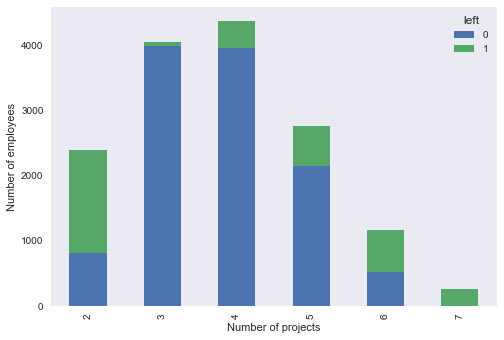

In [39]:
tab = pd.crosstab([df['number_project']],df['left'])
g = tab.plot(kind='bar', stacked=True, grid=False);
g.set_xlabel('Number of projects');
g.set_ylabel('Number of employees');

## Clustering and investigation

In the previous section, we noticed that there was some clear clustering going on with leavers. For example, looking at the satisfaction level vs last evaluation variables for those that left, we have:

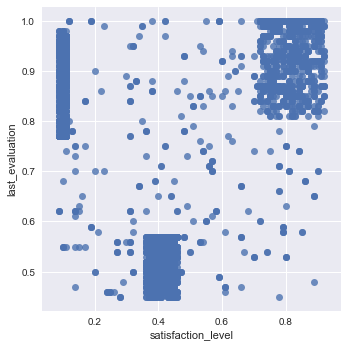

In [102]:
g = sns.lmplot('satisfaction_level', 'last_evaluation', data=df[df["left"] == 1], fit_reg=False, scatter=True);

Now we will try to cluster the data into three groups. We'll just use the continuous variables because they seperate the groups well. We know there are three groups, so we'll use a KMeans algorithm. 

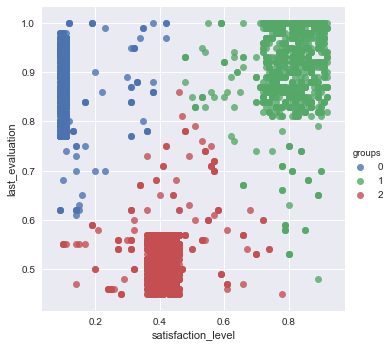

In [153]:
from sklearn import cluster
left = df[df["left"] == 1].reindex()

kmeans_groups = cluster.KMeans(n_clusters=3).fit_predict( left[['satisfaction_level', 'last_evaluation']])
left['groups'] = kmeans_groups

g = sns.lmplot('satisfaction_level', 'last_evaluation', hue='groups', data=left, fit_reg=False, scatter=True);

Now we'll investig